# IAB - Hands-on Tutorial for Link Analysis

Welcome to IAB - hands-on tutorial for link analysis.
In this tutorial, we will study several techniques for link analysis in graphs.
This tutorial consists of three sessions and one homework, and each of them will handle the following topic:

* **Session 1**. Tutorial on PageRank - Part 1 (60 mins)
* **Session 2**. Tutorial on PageRank - Part 2 (60 mins)
* <span style="color:blue">**Session 3**. Tutorial on Topic-specific PageRank (120 mins)</span>
* **Homework**. Implementation of HITS

We recommend fully understanding the lecture videos related to link analysis (or ranking) models such as PageRank, Topic-specific PageRank, and HITS before entering this tutorial since we will not explain the theoretical backgrounds on these techniques during the tutorial.
We will mainly focus on how to implement the algorithms of those models and how to rank nodes in real-world graphs using those ranking models.

The main contributors of this material are as follows:
* *Jihyeong Jeon* (jeonjihyeong@gmail.com)
* *Jaeri Lee* (jlunits2@gmail.com)
* *Jong-eun Lee* (kjayjay40@gmail.com)
* *U Kang* (ukang@snu.ac.kr)
------

------
## Session 3. Tutorial on Topic-specific PageRank (120 mins)
In this session, we will explore how to implement PageRank in Python.
The main goals of this session are summarized as follows:
* **Goal 1.** How to implement Topic-specific PageRank based on sparse matrices using `numpy` and `scipy` in Python
* **Goal 2.** To perform a qualitative analysis of the ranking result from Topic-specific PageRank in real-world networks

The outline of this session is as follows:
* **Step 1.** Review Topic-specific PageRank
* **Step 2.** Implement Topic-specific PageRank - the sparse matrix version
* **Step 3.** Validate your Topic-specific PageRank implementation
* **Step 4.** Qualitative analysis of the ranking result from Topic-specific PageRank

-----
### Step 1. Review Topic-specific PageRank (a.k.a. Personalized PageRank)

In this step, we will review Topic-specific PageRank.
Note that Topic-specific PageRank is also known as Personalized PageRank (PPR) or Random Walk with Restart (RWR).
As described in the lecture video, the main purpose of Topic-specific PageRank is to obtain a ranking w.r.t. given topics (or seed nodes).
Since the ranking result is biased toward the given seed nodes, that's why it is called Personalized PageRank.

#### Step 1-1. Mathematical definition of Topic-specific PageRank
The mathematical definition of Topic-specific PageRank is very similar to that of PageRank.

##### Problem definition of Topic-specific PageRank (Personalized PageRank)
* **Input**: adjacency matrix $\mathbf{A} \in \mathbb{R}^{n \times n}$ of a graph $G=(V, E)$, teleport probability $\beta$, and set of seeds $S$
* **Output**: the Personalized PageRank (PPR) score vector $\mathbf{r} \in \mathbb{R}^{n}$ such that

$$\mathbf{r} = (1-\beta)\mathbf{\tilde{A}}^{\top}\mathbf{r} + \beta\mathbf{q}$$

- Note that the equation of PPR is the same with that of PageRank except for the query vector $\mathbf{q}$
    - $\mathbf{q}$ is a query vector where $q_{s}=\frac{1}{|S|}$ for $s \in S$. For other node $u$, $q_{u} = 0$.

The definitions of adjacency matrix $\mathbf{A}$ and row-normalized adjacency matrix $\mathbf{\tilde{A}}$ are the same (please see Session 1 if you want to review).

-----
### Step 2. Implement Topic-specific PageRank - the sparse matrix version

We are going to implement the sparse matrix version of Topic-specific PageRank in Python.

#### Step 2-1. Set up requirements for this tutorial

As in the previous sessions, we first import required packages as follows:

In [ ]:
try:
    import numpy
except ImportError:
    print("numpy is not installed, type pip install numpy")

try:
    import scipy
except ImportError:
    print("scipy is not installed, type pip install scipy")

try:
    import matplotlib
except ImportError:
    print("matplotlib is not installed, type pip install matplotlib")

try:
    import pandas
except ImportError:
    print("pandas is not installed, type pip install pandas")

try:
    from IPython.display import display
except ImportError:
    print("ipython is not installed, type pip install ipython")

#### Step 2-2. Implement the phase for loading the graph dataset
In this step, we will implement the phase for loading the graph dataset of the sparse matrix version of Personalized PageRank.
We first need to import the following packages for this.

In [ ]:
# the below commands restrict the number of computation threads to 1
import os
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

import numpy as np
from scipy.sparse import csr_matrix, find
import pandas as pd

As in Session 2, we implement the following function.
Note that we do not need to modify the function since the functionality in the version is the same as that of Session 2.

In [ ]:
class SparsePPR:
    def load_graph_dataset(self, data_home, is_undirected=False):
        '''
        Load the graph dataset from the given directory (data_home)

        inputs:
            data_home: string
                directory path conatining a dataset (edges.tsv, node_labels.tsv)
            is_undirected: bool
                if the graph is undirected
        '''
        # Step 1. self file paths from data_home
        edge_path = "{}/edges.tsv".format(data_home)


        # Step 2. read the list of edges from edge_path
        edges = np.loadtxt(edge_path, dtype=int)
        n = int(np.amax(edges[:, 0:2])) + 1

        # Step 3. convert the edge list to the weighted adjacency matrix
        rows = edges[:, 0]
        cols = edges[:, 1]
        weights = edges[:, 2]
        self.A = csr_matrix((weights, (rows, cols)), shape=(n, n))
        if is_undirected == True:
            self.A = self.A + self.A.T

        # Step 4. set n (# of nodes) and m (# of edges)
        self.n = self.A.shape[0]     # number of nodes
        self.m = self.A.nnz          # number of edges

In [ ]:
class SparsePPR(SparsePPR):
    def load_node_labels(self, data_home):
        '''
        Load the node labels from the given directory (data_home)

        inputs:
            data_home: string
                directory path conatining a dataset
        '''
        label_path = "{}/node_labels.tsv".format(data_home)
        self.node_labels = pd.read_csv(label_path, sep="\t")

Let's check if the function is correctly implemented.
We will use the small dataset at `./data/small` as before.

In [ ]:
sppr = SparsePPR()
sppr.load_graph_dataset('/content/drive/MyDrive/data/small', is_undirected=False)
print("The number n of nodes: {}".format(sppr.n))
print("The number m of edges: {}".format(sppr.m))

The number n of nodes: 29
The number m of edges: 376


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from scipy.sparse import spdiags

As described in Session 1, we aim to implement the following operation in this phase:

$$\mathbf{\tilde{A}} = \mathbf{D}^{-1}\mathbf{A}$$

Note that the function `normalize` of `SparsePPR` is also the same with that of `SparsePageRank` (Session 2).
Hence, we use the same code from `SparsePageRank` as follows:

In [ ]:
class SparsePPR(SparsePPR):
    def normalize(self):
        '''
        Perform the row-normalization of the given adjacency matrix

        outputs:
            nA: np.ndarray (n x n matrix)
                the row-normalized adjacency matrix of the given graph
            d: np.ndarray (n x 1 vector)
                the out-degree vector
        '''
        d = self.A.sum(axis=1) # 중요함. since A is csr_matrix, the result of sum() is not a normal vector
        d = np.asarray(d).flatten() # to make it vector

        d = np.maximum(d, np.ones(self.n))
        invd = 1.0 / d
        invD = spdiags(invd, 0, self.n, self.n)

        self.nA = invD.dot(self.A)
        self.nAT = self.nA.T

        self.out_degrees = d

The debugging of the above function can be performed by using the following codes used in the previous sessions.

In [ ]:
sppr = SparsePPR()
sppr.load_graph_dataset('/content/drive/MyDrive/data/small', is_undirected=False)
sppr.normalize()

# check the sum of each row in the row-normalized matrix nA
row_sums = np.asarray(sppr.nA.sum(axis=1)).flatten()
for (i, degree, row_sum) in zip(range(sppr.n), sppr.out_degrees, row_sums):
    print("node: {:2d}, out-degree: {:2d},  row_sum: {:.2f}".format(i, int(degree), row_sum))

node:  0, out-degree: 14,  row_sum: 1.00
node:  1, out-degree: 15,  row_sum: 1.00
node:  2, out-degree: 17,  row_sum: 1.00
node:  3, out-degree: 23,  row_sum: 1.00
node:  4, out-degree: 27,  row_sum: 1.00
node:  5, out-degree: 27,  row_sum: 1.00
node:  6, out-degree: 12,  row_sum: 1.00
node:  7, out-degree: 14,  row_sum: 1.00
node:  8, out-degree: 16,  row_sum: 1.00
node:  9, out-degree: 12,  row_sum: 1.00
node: 10, out-degree: 14,  row_sum: 1.00
node: 11, out-degree: 10,  row_sum: 1.00
node: 12, out-degree: 13,  row_sum: 1.00
node: 13, out-degree:  8,  row_sum: 1.00
node: 14, out-degree:  9,  row_sum: 1.00
node: 15, out-degree:  5,  row_sum: 1.00
node: 16, out-degree:  6,  row_sum: 1.00
node: 17, out-degree:  1,  row_sum: 1.00
node: 18, out-degree:  6,  row_sum: 1.00
node: 19, out-degree: 13,  row_sum: 1.00
node: 20, out-degree: 15,  row_sum: 1.00
node: 21, out-degree: 19,  row_sum: 1.00
node: 22, out-degree: 12,  row_sum: 1.00
node: 23, out-degree: 16,  row_sum: 1.00
node: 24, out-de

#### Step 2-4. Implement the iterative phase

The implementation of the iterative phase of `SparsePPR` is almost the same as that of `SparsePageRank` except for how to treat given seed nodes.
For brevity, we assume the index of a seed is in the range of node index.
Also, we will consider the deadend issue as in Session 2.
Based on those considerations, let's implement the iterative phase of `SparsePPR` using the following algorithm.

<img src="./images/iterative-algorithm-ppr.png" width="400">

In [ ]:
class SparsePPR(SparsePPR):
    def iterate_PPR(self, seeds, b=0.15, epsilon=1e-9, maxIters=100, handles_deadend=True):
        '''
        ///Try it yourself!///
        Iterate the Personalized PageRank equation to obtain the PageRank score vector

        inputs:
            seeds: list
                the set of seed nodes
            b: float (between 0 and 1)
                the teleport probability
            epsilon: float
                the error tolerance of the iteration
            maxIters: int
                the maximum number of iterations
            handles_deadend: bool
                if it handles the deadend issue

        outputs:
            p: np.ndarray (n x 1 vector)
                the final PageRank score vector
            residuals: list
                the list of residuals over the iteration

        '''
        p = np.zeros(self.n)           # pagerank score vector
        residuals = []                 # set the list for residuals over iterations

        q=np.zeros(self.n)
        q[seeds]=1.0/len(seeds)
        old_r=q
        residuals=[]

        pass # TODO: implement Algorithm 1
        for t in range(maxIters):
          if handles_deadend:
            r=(1-b)*(self.nAT.dot(old_r))
            T=np.sum(r)
            r=r+(1-T)*q

          else:
            r=(1-b)*(self.nAT.dot(old_r))+(b*q)

          residual=np.linalg.norm(r - old_r,1)
          residuals.append(residual)
          old_r = r

          if residual < epsilon:
            break

        return p, residuals

Let's check the implementation is correctly performed.
We will briefly check each personalized ranking result using `pandas`.
See the following code where a seed node is given.
Note that the given seed node should have a high ranking score.

In [ ]:
import pandas as pd

def rank_nodes(ranking_scores, topk=-1):
    sorted_nodes = np.flipud(np.argsort(ranking_scores))
    sorted_scores = ranking_scores[sorted_nodes]
    ranking_results = pd.DataFrame()
    ranking_results["node_id"] = sorted_nodes
    ranking_results["score"] = sorted_scores

    return ranking_results[0:topk]

In [ ]:
sppr = SparsePPR()
sppr.load_graph_dataset('/content/drive/MyDrive/data/small', is_undirected=False)
sppr.normalize()

seeds = [0]
r, _ = sppr.iterate_PPR(seeds, b=0.15, epsilon=1e-9, maxIters=100)
print("The sum of the PageRank score vector: {:.2f}".format(np.sum(r)))
display(rank_nodes(r, 10))

The sum of the PageRank score vector: 0.00


,node_id,score
0,28,0.0
1,13,0.0
2,1,0.0
3,2,0.0
4,3,0.0
5,4,0.0
6,5,0.0
7,6,0.0
8,7,0.0
9,8,0.0


Let's provide a set of seeds to compute the personalized ranking w.r.t. the seed set.
In this case, each seed node in the set should have a high score compared to other nodes.

In [ ]:
seeds = [0, 2, 3]
r, _ = sppr.iterate_PPR(seeds, b=0.15, epsilon=1e-9, maxIters=100)
print("The sum of the PageRank score vector: {:.2f}".format(np.sum(r)))
display(rank_nodes(r, 10))

The sum of the PageRank score vector: 0.00


,node_id,score
0,28,0.0
1,13,0.0
2,1,0.0
3,2,0.0
4,3,0.0
5,4,0.0
6,5,0.0
7,6,0.0
8,7,0.0
9,8,0.0


-----
### Step 3. Validate your Topic-specific PageRank implementation

We will validate the implementation of Topic-specific PageRank.
Since the validation and implementation techniques are the same, we will do not repeat describing the details on this step (also, you do not need to fill the below cells).
Let's run each cell and check the results.

#### Step 3-1. Check if the residual monotonically decrease

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13}) # set the font-size in the figure

def plot_residuals(residuals, title):
    plt.semilogy(residuals, marker='o', markersize=5)
    plt.title(title)
    plt.ylim(ymin=1e-10, ymax=1e-0)
    plt.ylabel('Residual')
    plt.xlabel('# of iterations')
    plt.grid(True)
    plt.show()

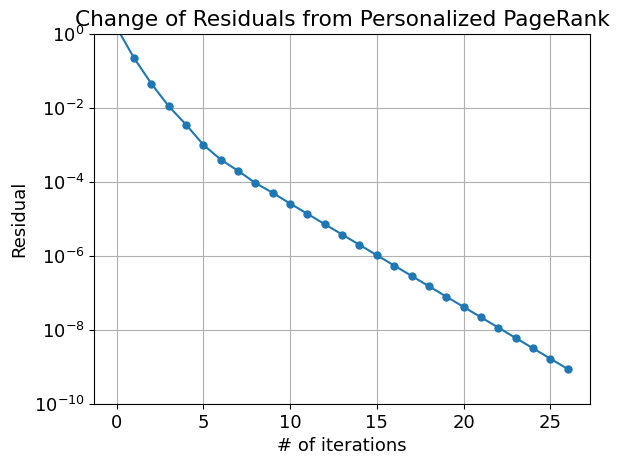

In [ ]:
seeds = [0, 2, 3]
r, residuals = sppr.iterate_PPR(seeds, b=0.15, epsilon=1e-9, maxIters=100)

plot_residuals(residuals, 'Change of Residuals from Personalized PageRank')

#### Step 3-2. Check if the iterative solution is equal to the exact solution of Personalized PageRank

The closed form of the equation of PPR is the same as that of PageRank.
Let's see the final closed equation of PPR.

$$
\mathbf{r} = \beta\left(\mathbf{I} - (1-\beta)\mathbf{\tilde{A}}^{\top}\right)^{-1}\mathbf{q} \\
$$

To implement the function for the exact solution, we just need to handle the query vector $\mathbf{q}$ in the previous code.

In [ ]:
class SparsePPR(SparsePPR):
    def compute_exact_PPR(self, seeds, b=0.15):
        '''
        Compute the exact PageRank score vector from the closed form

        inputs:
            b: float (between 0 and 1)
                the teleport probability
        outputs:
            p: np.ndarray (n x 1 vector)
                the final PageRank score vector
        '''
        q = np.zeros(self.n)
        q[seeds] = 1.0/len(seeds)

        H = np.eye(self.n) - (1.0 - b)*self.nAT
        invH = np.linalg.inv(H)

        r = b*(invH.dot(q))

        return np.asarray(r).flatten()

Let's check the error between the exact and iterative solutions of Personalized PageRank.

In [ ]:
sppr = SparsePPR()
sppr.load_graph_dataset('/content/drive/MyDrive/data/small', is_undirected=False)
sppr.normalize()

seeds = [0, 2, 3]
r_exact = sppr.compute_exact_PPR(seeds, b=0.15)
r_iter, _ = sppr.iterate_PPR(seeds, b=0.15, epsilon=1e-9, maxIters=100)

error = np.linalg.norm(r_exact - r_iter, 1)
print("Error between exact and iterative PPR scores: {:e}".format(error))

Error between exact and iterative PPR scores: 1.000000e+00


-----
### Step 4. Qualitative analysis of the ranking result from Topic-specific PageRank

In this step, we will explore a user-item network based on the ranking results of Topic-specific PageRank.

We briefly describe the dataset used in this analysis.
The name of the dataset is *movielens-100k* which is an undirected network of movie rating data.
Each node represents a *user* or a *movie*, and an weighted edge between user $u$ and movie $i$ indicates an integer rating (the weight of the edge) that the user rates the movie, which is ranged between $1$ and $5$.
The dataset is located at `./data/movielens-100k`.
The statistic of the dataset is as follows:

| Statistic | Value |
| --- | --- |
| $n$: the number of nodes | 2,625 |
| $m$: the number of edges | 100,000 |
| the range of ratings | 1 ~ 5 |
| the number of users | 943 |
| the number of movies | 1,682 |

Also, each user or movie has its attributes.
A user has `name`, `gender`, `age` and `job`.
A movie has `name` and `genres`.
Those attributes are aggregated at one file called `node_labels.tsv` for brevity.
Let's load and check the dataset.
Note that the graph is undirected

In [ ]:
data_home = '/content/drive/MyDrive/data/movielens-100k'
sppr = SparsePPR()
sppr.load_graph_dataset(data_home, is_undirected=True)
sppr.load_node_labels(data_home)

print("The number n of nodes: {}".format(sppr.n))
print("The number m of edges: {}".format(sppr.m))

# print the heads (5) of the node labels
print('\nThe top-5 heads of the node labels:')
display(sppr.node_labels.head(5))

# print the tails (5) of the node labels
print('\nThe bottom-5 tails of the node labels:')
display(sppr.node_labels.tail(5))

The number n of nodes: 2625
The number m of edges: 200000

The top-5 heads of the node labels:


,node_id,type,name,gender/genres,age,job
0,0,user,james,M,24.0,technician
1,1,user,patricia,F,53.0,other
2,2,user,robert,M,23.0,writer
3,3,user,michael,M,24.0,technician
4,4,user,elizabeth,F,33.0,other



The bottom-5 tails of the node labels:


,node_id,type,name,gender/genres,age,job
2620,2620,movie,Mat' i syn (1997),drama,NaN,NaN
2621,2621,movie,B. Monkey (1998),romance;thriller,NaN,NaN
2622,2622,movie,Sliding Doors (1998),drama;romance,NaN,NaN
2623,2623,movie,You So Crazy (1994),comedy,NaN,NaN
2624,2624,movie,Scream of Stone (Schrei aus Stein) (1991),drama,NaN,NaN


#### Step 4-1.  Qualitative analysis on a personalized ranking w.r.t. a specific user.

Now, we will do a qualitative analysis on a personalized ranking w.r.t. a specific user.
Before looking into the personalized ranking, we need to check the user's watch history to figure out characteristics of the user.
The following code reports the user's demography information and watch history.

In [ ]:
class SparsePPR(SparsePPR):
    def show_user_history(self, user_id):
        print("user_id: {}, demographic infomration:".format(user_id))
        display(self.node_labels.iloc[[user_id]])
        _, movie_ids, ratings = find(self.A[user_id, :])
        movie_labels = self.node_labels.iloc[movie_ids]
        movie_labels.insert(0, "rating", ratings)
        print("user_id: {}, watch history:".format(user_id))
        movie_labels = movie_labels[["node_id", "type", "name", "gender/genres", "rating"]]
        display(movie_labels.sort_values(by=["rating"], ascending=False))

Our target user's node id is `500`, and his watch history is as follows:

In [ ]:
data_home = "/content/drive/MyDrive/data/movielens-100k"
sppr = SparsePPR()
sppr.load_graph_dataset(data_home, is_undirected=True)
sppr.load_node_labels(data_home);
sppr.normalize()

sppr.show_user_history(user_id=500)

user_id: 500, demographic infomration:


,node_id,type,name,gender/genres,age,job
500,500,user,emil,M,22.0,student


user_id: 500, watch history:


,node_id,type,name,gender/genres,rating
1092,1092,movie,Swingers (1996),comedy;drama,5
2039,2039,movie,"Hate (Haine, La) (1995)",drama,5
2009,2009,movie,Bottle Rocket (1996),comedy,5
1069,1069,movie,"Godfather, The (1972)",action;crime;drama,5
1417,1417,movie,Trainspotting (1996),drama,5
...,...,...,...,...,...
1187,1187,movie,"Devil's Own, The (1997)",action;drama;thriller;war,3
1348,1348,movie,Thinner (1996),horror;thriller,3
1191,1191,movie,Austin Powers: International Man of Mystery (1...,comedy,3
1216,1216,movie,Sabrina (1995),comedy;romance,3


Seemingly, the user has frequently watched (and prefer) `drama`, `comedy`, `romance`, and `thriller` movies.

We use the following code to rank nodes regardless of node type (the below codes are from the previous session).

In [ ]:
class SparsePPR(SparsePPR):
    def rank_nodes(self, ranking_scores, topk=-1):
        '''
        Rank nodes in the order of given ranking scores.
        This function reports top-k rankings.

        inputs:
            ranking_scores: np.ndarray
                ranking score vector
            topk: int
                top-k ranking parameter, default is -1 indicating report all ranks
        '''
        sorted_nodes = np.flipud(np.argsort(ranking_scores)) # argsort in the descending order
        sorted_scores = ranking_scores[sorted_nodes]         # sort the ranking scores
        ranks = range(1, self.n+1) # 0~n-1

        result_labels = self.node_labels.iloc[sorted_nodes][0:topk]
        result_labels.insert(0, "rank", ranks[0:topk])
        result_labels["score"] = sorted_scores[0:topk]
        result_labels.reset_index(drop = True, inplace = True)
        return result_labels

Let's test the function on a personalized ranking.

In [ ]:
data_home = "/content/drive/MyDrive/data/movielens-100k"
sppr = SparsePPR()
sppr.load_graph_dataset(data_home, is_undirected=True)
sppr.load_node_labels(data_home);
sppr.normalize()

seeds = [500]
r, _ = sppr.iterate_PPR(seeds, b=0.15, epsilon=1e-9, maxIters=1000)
pd.set_option('display.max_rows', 10)
display(sppr.rank_nodes(r, topk=100))

,rank,node_id,type,name,gender/genres,age,job,score
0,1,2624,movie,Scream of Stone (Schrei aus Stein) (1991),drama,NaN,NaN,0.0
1,2,880,user,burt,M,39.0,marketing,0.0
2,3,878,user,gena,F,33.0,administrator,0.0
3,4,877,user,deirdre,F,50.0,educator,0.0
4,5,876,user,barton,M,30.0,other,0.0
...,...,...,...,...,...,...,...,...
95,96,951,movie,Dead Man Walking (1995),drama,NaN,NaN,0.0
96,97,950,movie,Babe (1995),children's;comedy;drama,NaN,NaN,0.0
97,98,949,movie,Twelve Monkeys (1995),drama;sci-fi,NaN,NaN,0.0
98,99,948,movie,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,drama,NaN,NaN,0.0


As you can see in the table, this ranking result contains nodes of movies as well as those of users. For better analysis, we need to implement such reporting functions according to node type. First, we implement `rank_users` function which reports ranking results for only users.

In [ ]:
class SparsePPR(SparsePPR):
    def rank_users(self, ranking_scores, topk=-1):
        user_labels = self.node_labels[self.node_labels.type == "user"]
        user_node_ids = user_labels["node_id"].values
        user_ranking_scores = ranking_scores[user_node_ids]

        sorted_indices = np.flipud(np.argsort(user_ranking_scores))
        sorted_users = user_node_ids[sorted_indices]
        sorted_scores = user_ranking_scores[sorted_indices]
        ranks = range(1, len(user_node_ids)+1)

        result_labels = self.node_labels.iloc[sorted_users][0:topk]
        result_labels.insert(0, "rank", ranks[0:topk])
        result_labels["score"] = sorted_scores[0:topk]
        result_labels.reset_index(drop = True, inplace = True)
        return result_labels

Let's see the example of the result from the function.

In [ ]:
data_home = "/content/drive/MyDrive/data/movielens-100k"
sppr = SparsePPR()
sppr.load_graph_dataset(data_home, is_undirected=True)
sppr.load_node_labels(data_home);
sppr.normalize()

seeds = [500]
r, _ = sppr.iterate_PPR(seeds, b=0.15, epsilon=1e-9, maxIters=100)
display(sppr.rank_users(r, topk=10))

,rank,node_id,type,name,gender/genres,age,job,score
0,1,942,user,chang,M,22.0,student,0.0
1,2,309,user,wendell,M,37.0,educator,0.0
2,3,321,user,gerard,M,20.0,student,0.0
3,4,320,user,blanche,F,49.0,educator,0.0
4,5,319,user,luke,M,19.0,student,0.0
5,6,318,user,oliver,M,38.0,programmer,0.0
6,7,317,user,trevor,M,65.0,retired,0.0
7,8,316,user,shannon,M,22.0,administrator,0.0
8,9,315,user,harriet,F,43.0,other,0.0
9,10,314,user,donnie,M,31.0,educator,0.0


As seen in the table, there are many students in the top-$10$ ranking list.
Note that the querying user ($500$, emil) is also a student.
These results imply that the personalized ranking on the user is able to capture other users having the similar preference to the querying user.

Next, we see `rank_movies` function which reports ranking results for only movies.
Since the implementation is a little bit complex, we provide the full implementation of the function.
This function additionally considers `seeds` and `shows_unseen` arguments since we sometimes want to recommend movies unseen by a user or users.
Suppose `seeds` indicate user node ids.
If `shows_unseen` is `True`, then the function reports the ranking result for only unseen movies which can be interpreted as a recommendation list.
Otherwise, it will consider all movies to rank.

In [ ]:
from functools import reduce

class SparsePPR(SparsePPR):
    def rank_movies(self, seeds, ranking_scores, topk=-1, shows_unseen=True):
        movie_labels = self.node_labels.loc[self.node_labels["type"] == "movie"]
        movie_node_ids = movie_labels["node_id"].values
        movie_ranking_scores = ranking_scores[movie_node_ids]

        _, seen_movie_ids, _ = find(self.A[seeds, :])
        seen_movie_ids = np.unique(seen_movie_ids)
        masks = [movie_node_ids == seen_movie for seen_movie in seen_movie_ids]
        seen_mask = reduce(np.logical_or, masks)

        sorted_indices = np.flipud(np.argsort(movie_ranking_scores))
        sorted_movies = movie_node_ids[sorted_indices]
        sorted_scores = movie_ranking_scores[sorted_indices]
        sorted_seen_mask = seen_mask[sorted_indices]
        ranks = range(1, len(movie_node_ids)+1)

        result_labels = self.node_labels.iloc[sorted_movies]
        result_labels.insert(0, "rank", ranks)
        result_labels.insert(0, "score", sorted_scores)
        result_labels.insert(0, "seen", sorted_seen_mask)

        if shows_unseen:
            result_labels = result_labels.loc[result_labels["seen"] == False]
            result_labels["rank"] = range(1, result_labels.shape[0]+1)

        result_labels = result_labels[0:topk]
        result_labels.reset_index(drop = True, inplace = True)
        return result_labels[["rank", "node_id", "type", "name", "gender/genres", "seen", "score"]]

Let's see the example of the result from the function.

In [ ]:
data_home = "/content/drive/MyDrive/data/movielens-100k"
sppr = SparsePPR()
sppr.load_graph_dataset(data_home, is_undirected=True)
sppr.load_node_labels(data_home);
sppr.normalize()

seeds = [500]
r, _ = sppr.iterate_PPR(seeds, b=0.15, epsilon=1e-9, maxIters=100)
display(sppr.rank_movies(seeds, r, topk=20, shows_unseen=True))

,rank,node_id,type,name,gender/genres,seen,score
0,1,2624,movie,Scream of Stone (Schrei aus Stein) (1991),drama,False,0.0
1,2,1520,movie,Demolition Man (1993),action;sci-fi,False,0.0
2,3,1496,movie,Waterworld (1995),action;adventure,False,0.0
3,4,1497,movie,White Man's Burden (1995),drama,False,0.0
4,5,1498,movie,Wild Bill (1995),western,False,0.0
...,...,...,...,...,...,...,...
15,16,1509,movie,Wes Craven's New Nightmare (1994),horror,False,0.0
16,17,1510,movie,Speed (1994),action;romance;thriller,False,0.0
17,18,1511,movie,Wolf (1994),drama;horror,False,0.0
18,19,1512,movie,Wyatt Earp (1994),western,False,0.0


Note that the querying user frequently watched `drama`, `comedy`, `romance`, and `thriller` movies.
Also, there are many of these kinds of movies in the recommendation list.

-----
## Session 3. Summary

In this session, we implemented Topic-specific PageRank (the sparse matrix version) in Python.
More specifically, we are able to answer the following goals now.

* **Goal 1.** How to implement Topic-specific PageRank based on sparse matrices using `numpy` and `scipy` in Python
    - We implemented the iterative algorithm for Topic-specific PageRank based on sparse matrices.
* **Goal 2.** To perform a qualitative analysis of the ranking result from Topic-specific PageRank in real-world networks
    - We performed a qualitative analysis on the `movielens-100k` dataset which is a real-world network.